In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from matplotlib import pyplot as plt
from skimage import exposure 
from skimage.exposure import match_histograms 
from skimage.morphology import (erosion, dilation, closing, opening)
from PIL import Image
from skimage.feature import canny

from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage.draw import circle_perimeter
from skimage import color, img_as_ubyte
import skimage
from skimage import measure
from skimage import io, morphology
from scipy.spatial import distance
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt

In [2]:
from load_images import load_images_from_folder

In [3]:
def show_images(images) :
    n: int = len(images)
    f = plt.figure()
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i],cmap='gray', vmin=0, vmax=255)

    plt.show()

In [4]:
def define_circle(p1, p2, p3):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])
    
    if abs(det) < 1.0e-6:
        return (None, np.inf)
    
    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det
    
    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

In [5]:
def define_point_one(x,y):
    """
     Return the first point on the circular arc of the OD located on the left side
     
    """    
    ind_y=[p for p,q in enumerate(y) if q==min(y)]    
    cent='false'     
    if abs(np.subtract(min(x[ind_y]),x.min()))>15 and abs(np.subtract(max(x[ind_y]),x.max()))>15:
        cent='true'
       # print(cent)
        ind_x=[p for p,q in enumerate(x) if q==min(x)]
        point_one=(y[ind_x[0]],x[ind_x[0]])
       # print(f'point_one:{point_one}')
        polint_location='top'
    
    if abs(np.subtract(min(x[ind_y]),x.min()))>abs(np.subtract(max(x[ind_y]),x.max())) and cent=='false':
        #point :down
        ind_x=[p for p,q in enumerate(x[ind_y]) if q==max(x[ind_y])]
        point_one=(y[ind_y[ind_x[0]]],x[ind_y[ind_x[0]]])
        polint_location='down'
    elif abs(np.subtract(min(x[ind_y]),x.min()))<=abs(np.subtract(max(x[ind_y]),x.max())) and cent=='false':
        ind_x=[p for p,q in enumerate(x[ind_y]) if q==min(x[ind_y])]      
        point_one=(y[ind_y[ind_x[0]]],x[ind_y[ind_x[0]]])
        polint_location='top'   
   # print(f'point_one : {point_one}')
    return point_one,polint_location

def define_point_two(x,y,coords,point_location) :
    """
     Return the second point on the circular arc of the OD located on the left side
     
    """ 
    if point_location == 'top':        
        ind_x=[p for p,q in enumerate(x) if q==max(x)]
       # print(y[ind_x])
        ind_y=[p for p,q in enumerate(y[ind_x]) if q==min(y[ind_x])][0]
        y[ind_y]
        coords
        cordinates=[]
        for i in range(len(coords)):
            if coords[i][0]<=y[ind_x[ind_y]] and coords[i][1]> (x.min()+x.max())/2:
                cordinates.append(i) 
        if len(cordinates) !=0 :
            point_two=coords[cordinates[-1]]  
    else:
        ind_x=[p for p,q in enumerate(x) if q==min(x)]
        y[ind_x]
        ind_y=[p for p,q in enumerate(y[ind_x]) if q==min(y[ind_x])][0]
        cordinates=[]
        for i in range(len(coords)):
            if coords[i][0]<y[ind_y] and coords[i][1]< (x.min()+x.max())/2:
                cordinates.append(i)      
        if len(cordinates) !=0:
            point_two=coords[cordinates[0]]
        else:
            point_two=(y[ind_y],x[ind_x][0])
    #print(f'point2 : {point_two}')        
    return point_two
        
def define_3_point(x,y):
    """
    Return the tree points on the circular arc of the OD located on the left side
    """
    coords=list(zip(y, x))    
    point_one,point_location=define_point_one(x,y)
    point_two= define_point_two(x,y,coords,point_location)
    distance1,distance2 = [],[]
    coords1=[]
    for ii in range(len(coords)):
        if coords[ii][0]> (int((y.max()-y.min())/2)+y.min()) and coords[ii][1]> x.min():
            coords1.append(ii)
            distance1.append(distance.euclidean(coords[ii],point_one))#coords[ind[0][0]]))
            distance2.append(distance.euclidean(coords[ii],point_two))#coords[ind[1][0]]))
    sub_dist=list(abs(np.subtract(distance1,distance2)))
    ind1=[p for p,q in enumerate(sub_dist) if q==min(sub_dist)][0]    
    pts = np.array([list(coords[coords1[ind1]]),point_one,point_two])
    return pts

In [6]:
def define_point_one_2(x,y):
    
    ind_y=[p for p,q in enumerate(y) if q==max(y)]    
    cent='false'    
    if abs(np.subtract(min(x[ind_y]),x.min()))>=15 and abs(np.subtract(max(x[ind_y]),x.max()))>=15:
        cent='true'
        #print(cent)
        ind_x=[p for p,q in enumerate(x) if q==min(x)]
        point_one=(y[ind_x[0]],x[ind_x[0]])
        polint_location='top'   
    if abs(np.subtract(min(x[ind_y]),x.min()))> abs(np.subtract(min(x[ind_y]),x.max())) and cent=='false':
        #point :down
        ind_x=[p for p,q in enumerate(x[ind_y]) if q==max(x[ind_y])]
        point_one=(y[ind_y[ind_x[0]]],x[ind_y[ind_x[0]]])
        polint_location='down'
    elif abs(np.subtract(min(x[ind_y]),x.min()))<= abs(np.subtract(min(x[ind_y]),x.max())) and cent=='false':
        ind_x=[p for p,q in enumerate(x[ind_y]) if q==min(x[ind_y])]        
        point_one=(y[ind_y[ind_x[0]]],x[ind_y[ind_x[0]]])
        polint_location='top'        
   # print(f'point_one :{point_one}')
    return point_one,polint_location

def define_point_two_2(x,y,coords,point_location) :
   
    print(point_location)
    if point_location == 'top':
        ind_x=[p for p,q in enumerate(x) if q==max(x)]
        ind_y=[p for p,q in enumerate(y[ind_x]) if q==max(y[ind_x])][0]      
        coords
        cordinates=[]
        for i in range(len(coords)):
            if (coords[i][0]>= y[ind_x[ind_y]] and coords[i][1]> (x.min()+x.max())/2 and
            abs(np.subtract(coords[i][1],x[ind_x[ind_y]]))<10):#int(x.max()-x.min())/6
                cordinates.append(i)  
        if len(cordinates) !=0:
            point_two=coords[cordinates[0]]
        else:
            point_two=(y[ind_x[ind_y]],x[ind_x[ind_y]])
            
        if len(cordinates) !=0:
            point_two=coords[cordinates[0]]  
    else:
        ind_x=[p for p,q in enumerate(x) if q==min(x)]
        y[ind_x]
        ind_y=[p for p,q in enumerate(y[ind_x]) if q==max(y[ind_x])][0]
        cordinates=[]
        for i in range(len(coords)):
            if coords[i][0]>y[ind_y] and coords[i][1]< (x.min()+x.max())/2:
                cordinates.append(i)
      
        if len(cordinates) !=0:
            point_two=coords[cordinates[0]]
        else:
            point_two=(y[ind_y],x[ind_x][0])
    #print(f'point_two:{point_two}')        
    return point_two
        
def define_3_point_2(x,y):
    """
    Return the tree points on the circular arc of the OD located on the rigth side
    """
    coords=list(zip(y, x))    
    point_one,point_location=define_point_one_2(x,y)
    point_two= define_point_two_2(x,y,coords,point_location)
    distance1,distance2 = [],[]
    cordinates=[]
    for ii in range(len(coords)):
        if coords[ii][0] < min(point_one[0],point_two[0]):
            
            cordinates.append(ii)
            distance1.append(distance.euclidean(coords[ii],point_one))#coords[ind[0][0]]))
            distance2.append(distance.euclidean(coords[ii],point_two))#coords[ind[1][0]]))
    sub_dist=list(abs(np.subtract(distance1,distance2)))
   # print(f'cordinates:{cordinates}')
    ind1=[p for p,q in enumerate(sub_dist) if q==min(sub_dist)][0]    
    pts = np.array([list(coords[cordinates[ind1]]),point_one,point_two])
    return pts

In [7]:
def detect_blob(image_gray):
    """
    Retuen the center and radius of the circular OD boundary by using blob algorithm  
    """
   
    blobs_log = blob_log(np.uint8(image_gray)*255,max_sigma=40, num_sigma=10,  threshold=.01)#max_sigma=20, num_sigma=10,
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2) 

    radius=[]
    for i in range(blobs_log.shape[0]) :
        radius.append(int(blobs_log[i,2]))

    ind=[p for p,q in enumerate(radius) if q==max(radius)][0]
    y=blobs_log[ind,1]#row
    x=blobs_log[ind,0]#column
    r = blobs_log[ind,2]
    cv2.circle(im_original, (int(y),int(x)), int(r), (255, 0, 0), 2)
    return y,x,r


In [8]:
def computing_OD_win_sorrunding(OD_center,OD_radius,OD_location,gray_img):
    """
     computing the window surronding OD
    """
    if np.subtract(round(OD_center[1]),OD_radius)>=0:
        first_row=np.subtract(round(OD_center[1]),round(OD_radius))
    else:
        first_row=0
        
    if np.add(round(OD_center[1]),OD_radius)<=gray_img.shape[0] :
        second_row=np.add(round(OD_center[1]),round(OD_radius))
    else:
        second_row=gray_img.shape[0]
        
    if np.subtract(round(OD_center[0]),OD_radius)>=0:
        first_col=np.subtract(round(OD_center[0]),round(OD_radius))
    else:
        first_col=0
        
    if np.add(round(OD_center[0]),OD_radius)<=gray_img.shape[1] :
        second_col=np.add(round(OD_center[0]),round(OD_radius))
    else:
        second_col=gray_img.shape[0]
        
    win_OD=gray_img[first_row:second_row,first_col:second_col]
    
    if OD_location=='disc_center':
        OD_win_ctr=(round(win_OD.shape[0]/2), round(win_OD.shape[1]/2))
        win_OD_1=win_OD.copy()    
        for p in range(win_OD.shape[0]):
            for q in range(win_OD.shape[1]):
                point=np.array((p,q))
                distance=np.linalg.norm(np.subtract(point,np.array(OD_win_ctr)))
                if distance>=OD_radius:
                    win_OD_1[p,q]=0
            
    if OD_location == 'macula_center':
        if OD_center[0]< int((gray_img.shape[1])/2):
            OD_win_ctr=(round(win_OD.shape[0]/2),0 )
        else:
            OD_win_ctr=(round(win_OD.shape[0]/2),win_OD.shape[1] ) 
        win_OD_1=win_OD.copy()    
        for p in range(win_OD.shape[0]):
            for q in range(win_OD.shape[1]):
                point=np.array((p,q))
                distance=np.linalg.norm(np.subtract(point,np.array(OD_win_ctr)))
                if distance>=OD_radius:
                    win_OD_1[p,q]=0
            

    img_cup_prep=np.zeros(gray_img.shape, dtype=np.uint8())
    img_cup_prep[first_row:second_row,first_col:second_col]=win_OD_1
   # show_images([gray_img,img_cup_prep])
    
    return img_cup_prep,win_OD_1

In [9]:
### loading data

data_path='./all/'
images,images_name=load_images_from_folder(data_path)

In [20]:
### analyzing the  OD candidates obtained from the Automorph:

kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
center=[]
propsa_f=[]
coords=[]
count_im=0
path_candidate_disc1='./OD_candidates/'

path_region_props='./analyzed_OD_candidate/'
if not os.path.exists(path_region_props):
        os.makedirs(path_region_props)

for filename in os.listdir(path_candidate_disc1):
   # filename='EYE00136_E_5088_cropped_segmented_corrected.OS'+'.png'
    S2=[]
    
    im0=cv2.imread(os.path.join(path_candidate_disc1,filename))
    im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY)    
    img=cv2.imread(os.path.join(data_path,filename))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray=cv2.resize(img_gray,im0.shape)
    ### remove pixels with the intensity lower than th00    
    x,y=np.where(im0>0)
    th00=0.2*(im0.mean())
    im0=np.multiply(np.where(im0>th00,1,0),im0)
    ###using opening morphology in order to seperate noise
    im_opened=np.uint8(opening(im0.copy(),kernel))
    x0,y0=np.where(np.uint8(im_opened)>0)
    th0=0.7*(im0[x0,y0].mean())
    imm=np.multiply(np.uint8(np.where(im_opened>0,1,0)),im0>th0)
    ###removing the regions with the big area, more than 15000, and then low regions, the areas lower than 1000 
    im_3=np.uint8(morphology.remove_small_objects(imm>0,15000))
    im_4=np.uint8(np.subtract(np.where(im0>0,1,0),im_3))
    im_4=np.uint8(np.where(im_4>0,1,0))
    im_4=np.uint8(morphology.remove_small_objects(im_4>0,1000))
    ### removing the pixels with the low likelihood of being OD
    image1=np.multiply(im_4,im0)
    x,y=np.where(image1!=0)   
    th=1.3*(image1.mean().mean())
    im_01=np.where(image1>(th),1,0)#
    im_10=morphology.remove_small_objects(im_01>0,1500)
    im_1=np.uint8(closing(im_10.copy(),kernel))
    
    ###labeling the OD candidates for the input image   
    IM=np.multiply(np.uint8(im_1),im0)
    labels = measure.label(im_1,connectivity=2)                       
    propsa = measure.regionprops(labels)
    num_propsa = len(propsa)
    areas=[]
    coords=[]
    box=[]
    I_mean=[]
    labels1=np.zeros(labels.shape)
   
    for label in propsa:       
        candidate_assesed=0 
        #analyzing the OD candidates located in the center of SLO images
        if label.bbox[1]> int(im0.shape[0]/6) and label.bbox[3]< (5*int(im0.shape[0]/6)):
       
            hight_width=(label.bbox[2]-label.bbox[0]) /(label.bbox[3]-label.bbox[1])
            width_higth=(label.bbox[3]-label.bbox[1]) /(label.bbox[2]-label.bbox[0])
            if hight_width<0.8 or width_higth<0.3:
                labels[label.coords[:,0],label.coords[:,1]]=0
                candidate_assesed=1
                num_propsa -= 1
                              
            if candidate_assesed==0 and label.area<2000 :
                labels[label.coords[:,0],label.coords[:,1]]=0
                candidate_assesed=1
                num_propsa -= 1
           
            if ((candidate_assesed==0 and np.subtract(label.bbox[2], label.bbox[0])>int(im0.shape[0]/3) ) or
                 (candidate_assesed==0 and np.subtract(label.bbox[3], label.bbox[1])>int(im0.shape[0]/3) ) ) :
                labels[label.coords[:,0],label.coords[:,1]]=0
                candidate_assesed=1
                num_propsa -= 1
                                
            if candidate_assesed==0 and label.area>15000 :
                labels[label.coords[:,0],label.coords[:,1]]=0
                candidate_assesed=1
                num_propsa -= 1 
                           
            if ((candidate_assesed==0 and label.bbox[0]<int(im0.shape[0]/5)) 
                      or (candidate_assesed==0 and label.bbox[2]>(4*int(im0.shape[0]/5)))):
                labels[label.coords[:,0],label.coords[:,1]]=0
                candidate_assesed=1
                num_propsa -= 1 
                               
            if label.solidity <0.75 and candidate_assesed==0:
                labels[label.coords[:,0],label.coords[:,1]]=0
                candidate_assesed=1
                num_propsa -= 1
                     
        else:
            ### analysing candidates not located in the center of the SLO images
            candidate_assesed=0
            hight_width=(label.bbox[2]-label.bbox[0]) /(label.bbox[3]-label.bbox[1])
            width_higth=(label.bbox[3]-label.bbox[1]) /(label.bbox[2]-label.bbox[0])
            if( hight_width <0.7 or hight_width>3.4 ):              
                candidate_assesed=1
                num_propsa -= 1
                labels[label.coords[:,0],label.coords[:,1]]=0  
             
            if(( candidate_assesed==0and abs(np.subtract(label.bbox[3], im0.shape[1]))>15 and label.area<2000 and label.bbox[3]>128 ) or
                   ( candidate_assesed==0 and abs(np.subtract(label.bbox[0], 0))>15 and label.area<2000 and label.bbox[1]<128 )):              
                candidate_assesed=1
                num_propsa -= 1
                labels[label.coords[:,0],label.coords[:,1]]=0  
              
            if  (candidate_assesed==0 and label.bbox[3]<im_1.shape[1]/2 and hight_width>2 and 
                    (label.bbox[1])>(im_1.shape[1]/10)):
                candidate_assesed=1
                num_propsa -= 1
                labels[label.coords[:,0],label.coords[:,1]]=0
          
            if candidate_assesed==0 and label.area<1000 :
                labels[label.coords[:,0],label.coords[:,1]]=0
                candidate_assesed=1
                num_propsa -= 1
              
            if candidate_assesed==0 and label.area>10000 :
                labels[label.coords[:,0],label.coords[:,1]]=0
                candidate_assesed=1
                num_propsa -= 1
              
            if ((candidate_assesed==0 and label.bbox[0]<int(im0.shape[0]/5)) or
                (candidate_assesed==0 and label.bbox[2]>(4*int(im0.shape[0]/5)))):            
                labels[label.coords[:,0],label.coords[:,1]]=0
                candidate_assesed=1
                num_propsa -= 1
          
            if label.solidity <0.5 and candidate_assesed==0:
                labels[label.coords[:,0],label.coords[:,1]]=0
                candidate_assesed=1
                num_propsa -= 1
               
        if candidate_assesed==0:
                areas.append(label.area)
                box.append(label.bbox)
                coords.append(label.coords)
                S2.append(label.solidity)
                I_mean.append(IM[label.coords[:,0],label.coords[:,1]].mean())  
                 
    if len(S2)==0:
        S2.append(0)
    labels1=np.zeros(labels.shape, dtype=np.uint8)
    if num_propsa>1  :
        
            coords2,areas2 =[],[]    
            ind1=[ii for ii,x in enumerate(I_mean) if x==max(I_mean)][0] 
            coords2.append(coords[ind1])
            areas2.append(areas[ind1])
                
            labels1[coords[ind1][:,0],coords[ind1][:,1]]=1
            #cv2.imwrite(save_path2+filename, labels1*128+img)
            cv2.imwrite(path_region_props+filename, np.where(labels1>0,255,0))
    else:
            if num_propsa==1:
                if areas[0]>15000:
                    labels[:,:]=0
            
            #cv2.imwrite(save_path2+filename,np.where(np.uint8(labels)>0,1,0)*128+img)
            cv2.imwrite(path_region_props+filename, np.where(labels>0,255,0))
 
    if count_im==0:
        pass
       # break
  

top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
down
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top


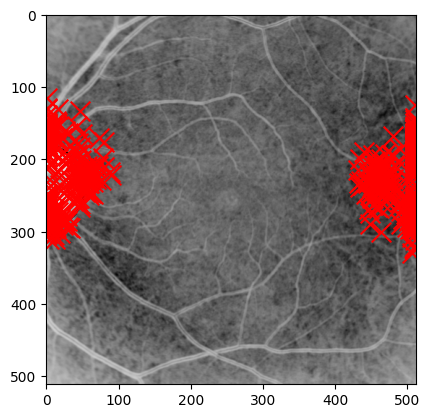

In [25]:
###OD boundary segmentation

save_path_OD='./OD_boundary_segmentation/'
if not os.path.exists(save_path_OD):
        os.makedirs(save_path_OD)
counts=0
list_values=[]
for filename in os.listdir(path_region_props):
   
   # filename='lotfi_m_265.OD.png'
    im_original0=cv2.imread(os.path.join(data_path,filename))
    im_original=cv2.resize(im_original0,(512,512))
    
    im0=cv2.imread(os.path.join(path_region_props,filename))
    im = cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY)
    image_gray   = skimage.morphology.convex_hull_object(im, connectivity=2)
    edges=canny(np.uint8(image_gray)*255)
    x,y=np.where(edges!=0)#x:row,y:col
    
    disc_location='disc_center'
    ### the boundary segmentation for OD located at the left side
    if len(y)!=0 and abs(np.subtract(y.min(), 0))<20 and abs(np.subtract(y.min(), y.max()))<85:
        pts = define_3_point(x,y)
        disc_location='macula_center'
        
    ### the boundary segmentation for OD located at the right side
    if (len(y)!=0 and abs(np.subtract(im.shape[1], y.max()))<20 and abs(np.subtract(y.min(), y.max()))<85) :
        pts = define_3_point_2(x,y)
        disc_location='macula_center'
        
    ###  the boundary segmentation for OD located at the center of the image
    if disc_location == 'disc_center' and len(y)!=0:
        image_color = color.gray2rgb(img_as_ubyte(np.uint8(image_gray)*255))
        y_c,x_c,r=detect_blob(image_gray)  
        cv2.imwrite(save_path_OD+filename, im_original)
        list_values.append([filename, disc_location, y_c, x_c,  r])

    if  disc_location == 'macula_center' and len(y)!=0:
        plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=200)    
        #compute center and radius of circle using 3 points in 2-space dimension
        # center: tuple type :first element:column, second element:row
        center, radius = define_circle(tuple(pts[0,:]),tuple(pts[1,:]),tuple(pts[2,:]))
        cv2.circle(im_original, (int(center[0]),int(center[1])), int(radius), (255, 255, 0), 2)
        plt.imshow(im_original*255)
        cv2.imwrite(save_path_OD+filename, im_original)
        list_values.append([filename, disc_location, center[0], center[1], radius])
    #counts+=1
    if counts==5:
        pass
        
df = pd.DataFrame(list_values, columns = ['image_name','OD_location','OD_center_x','OD_center_y','OD_width'])
df.to_csv('OD_information.csv', index=False)

In [24]:
### computing the windown sorrunding OD
save_path_cup_prp='./cup_pre_processed/'
if not os.path.exists(save_path_cup_prp):
        os.makedirs(save_path_cup_prp)
count=0
df_columns=list(df.columns)

for i in range(len(df)):
    
    img=cv2.imread(os.path.join(data_path,df[df_columns[0]][i])) 
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img=cv2.resize(gray_img,(512,512))
    gray_img=cv2.normalize(gray_img, None, 0, 255, cv2.NORM_MINMAX)
    
    #center: containing touple element in which the first and second elements indicate  column and row, respectively.
    OD_center=(df[df_columns[2]][i],df[df_columns[3]][i])
    #print(OD_center)
    OD_radius=df[df_columns[4]][i]
    OD_location=df[df_columns[1]][i]
   
    img_cup_prep,win_OD = computing_OD_win_sorrunding(OD_center,OD_radius,OD_location,gray_img)
    cup_image=cv2.cvtColor(np.uint8(win_OD),cv2.COLOR_GRAY2RGB)
    cv2.imwrite(save_path_cup_prp+df[df_columns[0]][i], cup_image)
    if count ==2 :
        pass
    count += 1